#### Install requirements and read in data

In [1]:
# !pip install scikit-video

In [1]:
import os, cv2, scipy.signal, skvideo.io, skvideo.motion, json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import sagemaker
from sagemaker.predictor import csv_serializer
from sklearn.preprocessing import Imputer
from IPython.display import clear_output
import time

from sagemaker import get_execution_role
role = get_execution_role()


In [2]:
vid_in_dir = 'mp4Vids/'
out_dir = "sendToAMT" # image sequence frames for labeling
# path_to_json = 'AMTresponses/' # response files

# 0-11 cards, 12-23 chess, 24-35 puzzle, 46-48 jenga
vid_name_list = ["cards_courtyard_T_B", "cards_courtyard_B_T", 
                 "cards_courtyard_H_S", "cards_courtyard_S_H",
                 "cards_livingroom_T_B", "cards_livingroom_B_T",
                 "cards_livingroom_H_S", "cards_livingroom_S_H",
                 "cards_office_T_H", "cards_office_H_T",
                 "cards_office_B_S", "cards_office_S_B",
                 
                 "chess_courtyard_T_B", "chess_courtyard_B_T", 
                 "chess_courtyard_H_S", "chess_courtyard_S_H",
                 "chess_livingroom_T_B", "chess_livingroom_B_T",
                 "chess_livingroom_H_S", "chess_livingroom_S_H",
                 "chess_office_T_B", "chess_office_B_T",
                 "chess_office_H_S", "chess_office_S_H",
                 
                 "puzzle_courtyard_T_H", "puzzle_courtyard_H_T", 
                 "puzzle_courtyard_B_S", "puzzle_courtyard_S_B",
                 "puzzle_livingroom_T_B", "puzzle_livingroom_B_T",
                 "puzzle_livingroom_H_S", "puzzle_livingroom_S_H",
                 "puzzle_office_H_B", "puzzle_office_B_H",
                 "puzzle_office_T_S", "puzzle_office_S_T",
                 
                 "jenga_courtyard_T_S", "jenga_courtyard_S_T", 
                 "jenga_courtyard_H_B", "jenga_courtyard_B_H",
                 "jenga_livingroom_T_B", "jenga_livingroom_B_T",
                 "jenga_livingroom_H_S", "jenga_livingroom_S_H",
                 "jenga_office_T_B", "jenga_office_B_T",
                 "jenga_office_H_S", "jenga_office_S_H",
                 "IMG_3715"]

vid_name = vid_name_list[1] # cards_courtyard_T_B
v1 = skvideo.io.vread(vid_in_dir + vid_name + " copy.mp4")
print("v1 shape: {}".format(v1.shape))
print("vid_name: {}".format(vid_name))

v1 shape: (2700, 720, 1280, 3)
vid_name: cards_courtyard_B_T


In [3]:
def clip_frame(in_frame):
    return in_frame[:2691,:,:,:]

# v1 = np.round(clip_frame(v1)/255.0, 6)
v1 = clip_frame(v1)

print("v1 shape:{}".format(v1.shape))

v1 shape:(2691, 720, 1280, 3)


In [4]:
v1_9 = v1.reshape(299, 9, 720, 1280, 3)

print("v1_9 shape:{}".format(v1_9.shape))

v1_9 shape:(299, 9, 720, 1280, 3)


In [5]:
# worker annotation path
# wa_path = "s3://piml-central/gestures4/cards_courtyard_B_T/gestures4/annotations/worker-response/iteration-1/"
wa_path = vid_name + "_labels_full/"

cols = ['datasetObjectId', 
        'confidence', 
        'jobName',
        'className',
        'humanAnnotated',
        'creationDate',
        'dataType',
        'gestures4']

labeled_df = pd.DataFrame(columns=cols)

json_files = [pos_json for pos_json in os.listdir(wa_path) if pos_json.endswith('.json')]

for l in range(len(json_files)):

    json_files = [pos_json for pos_json in os.listdir(wa_path) if pos_json.endswith('.json')] 
    f = open(wa_path + "/" + json_files[l])
    data = json.load(f)
    f.close()

    for i in range(len(data)):

        datasetObjectId = data[i]['datasetObjectId']
        confidence = data[i]['consolidatedAnnotation']['content']['gestures4-metadata']['confidence']
        jobName = data[i]['consolidatedAnnotation']['content']['gestures4-metadata']['job-name']
        className = data[i]['consolidatedAnnotation']['content']['gestures4-metadata']['class-name']
        humanAnnotated = data[i]['consolidatedAnnotation']['content']['gestures4-metadata']['human-annotated']
        creationDate = data[i]['consolidatedAnnotation']['content']['gestures4-metadata']['creation-date']
        dataType = data[i]['consolidatedAnnotation']['content']['gestures4-metadata']['type']
        gestures4 = data[i]['consolidatedAnnotation']['content']['gestures4']

        df = pd.DataFrame(data=[[datasetObjectId, 
                                 confidence, 
                                 jobName, 
                                 className,
                                 humanAnnotated,
                                 creationDate,
                                 dataType,
                                 gestures4]], columns=cols)

        labeled_df = labeled_df.append(df)


In [13]:
labeled_df.head()

,datasetObjectId,confidence,jobName,className,humanAnnotated,creationDate,dataType,gestures4
0,210,0.92,labeling-job/gestures4,No GRASP or RELEASE,yes,2019-06-01T10:50:12.383172,groundtruth/image-classification,8
0,277,0.92,labeling-job/gestures4,No GRASP or RELEASE,yes,2019-06-01T10:50:12.383192,groundtruth/image-classification,8
0,133,0.92,labeling-job/gestures4,No GRASP or RELEASE,yes,2019-06-01T10:50:12.383206,groundtruth/image-classification,8
0,132,0.92,labeling-job/gestures4,No GRASP or RELEASE,yes,2019-06-01T10:50:12.383217,groundtruth/image-classification,8
0,130,0.70,labeling-job/gestures4,Top Right Hand RELEASE,yes,2019-06-01T10:50:12.383229,groundtruth/image-classification,1


Label: Top Right Hand RELEASE, ObjectId: 130


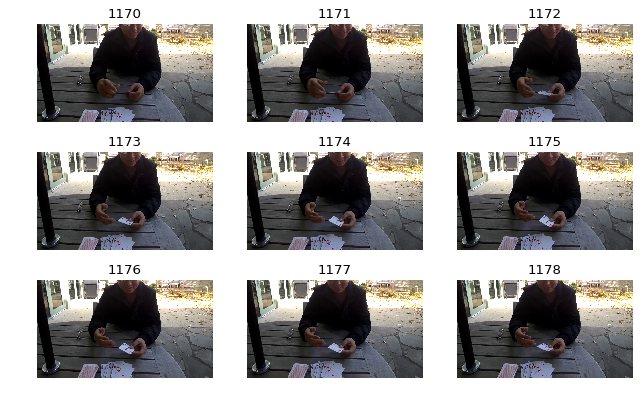

In [19]:
plt.figure(figsize=(8*1.2, 5*1.2), dpi=80, facecolor='w', edgecolor='k')

start_batch = 130
batches = 0

for batch in range(start_batch, start_batch + batches+1): 
    
    n_9batch = batch
    sample_frame = 0
    incr = 1

    clip_name = vid_name + "_" + str(n_9batch) + "_" + str(n_9batch*9) + "_" + str(n_9batch*9 + 8)

    for n in range(1, 10):

        plt.subplot(3, 3, n)
        plt.imshow(v1_9[n_9batch][sample_frame + (n-1)*incr])
        plt.axis('off')
        plt.title(n_9batch*9 + (n-1)*incr)
    
#     clear_output()
        
    label_name = str(labeled_df.loc[labeled_df["datasetObjectId"]==str(batch)]["className"][0])
    print("Label: {}, ObjectId: {}".format(label_name, str(batch)))
    plt.show()
    time.sleep(1)
    

In [20]:
labeled_df["datasetObjectId"] = labeled_df["datasetObjectId"].astype(int)
sorted_df = labeled_df.sort_values(by=["datasetObjectId"])

Y = sorted_df["gestures4"]
X = v1_9

In [21]:
print("X.shape: {}".format(X.shape))
print("Y.shape: {}".format(Y.shape))

X.shape: (299, 9, 720, 1280, 3)
Y.shape: (299,)


In [110]:
labels = ["Top Left Hand - GRASP", 
          "Top Left Hand - RELEASE",
          "Top Right Hand - GRASP", 
          "Top Right Hand - RELEASE",
          "Bottom Left Hand - GRASP", 
          "Bottom Left Hand - RELEASE",
          "Bottom Right Hand - GRASP", 
          "Bottom Right Hand - RELEASE",
          "No GRASP or RELEASE", 
          "More than one or OTHER"]

# labels = pd.DataFrame(labels, columns=["answerContent"]).reset_index()
# # labeled_df['answerContent'].join(pd.DataFrame(labels))
# result = pd.merge(labeled_df, labels, on='answerContent')
# print(labels)
# result

#### Read in subscription export from AWS DeepLens device (IOT subscription)

In [102]:
awsIOTpath = 'AWSIOTsubscriptions/'
json_files = [pos_json for pos_json in os.listdir(awsIOTpath) if pos_json.endswith('.json')]
f = open(awsIOTpath + "/" + json_files[0])
data = json.load(f)
f.close()
    

In [108]:
data['messages'][0]['payload']

{'No GRASP or RELEASE': 0.0001819133758544922,
 'Top Right Hand - GRASP': 0.0013265609741210938,
 'Bottom Right Hand - RELEASE': 0.998046875,
 'Top Right Hand - RELEASE': 0.0006928443908691406,
 'Bottom Right Hand - GRASP': 7.212162017822266e-06}

In [135]:
d = data['messages']

In [137]:
len(d)

100

In [23]:
# d = data['messages'][1]['payload']
# index = 0
# value = next(v for i, v in enumerate(d.itervalues()) if i == index)
# value

In [22]:
# labels

# pred = np.zeros(100, 10, 12)
# classes = list(d.items())

# for c_idx in range(len(classes)):
    
#     print(labels.index(classes[c_idx][0]))
#     print(classes[c_idx][1])